1.
Un site web doreşte să prezică rata zilnică p a utilizatorilor care finalizează o achiziţie. Se observă date zilnice privind
numărul k de utilizatori care finalizează achiziţia şi numărul total n de vizitatori zilnici (astfel, p = k/n), timp de o
săptămână. Observaţiile sunt:

● Ziua 1: k = 10, n = 100;

● Ziua 2: k = 15, n = 120;

● Ziua 3: k = 20, n = 150;

● Ziua 4: k = 5, n = 90;

● Ziua 5: k = 25, n = 200;

● Ziua 6: k = 12, n = 110;

● Ziua 7: k = 18, n = 130.
Dorim să estimăm rata pentru fiecare zi a săptămânii, dar şi rata medie. Presupunem că:

● rata zilnică p urmează o distribuţie Beta(α = 2, β = 2), care reflectă o preferinţă uşoară pentru valori apropiate
de 0.5, iar

● pentru fiecare zi, numărul de utilizatori care finalizează achiziţia ki este modelat ca o variabilă binomială: ki ∼ Binomial(ni, pi), unde ni este numărul total de utilizatori în ziua i.

a) Definiţi un model în PyMC care sa descrie contextul de mai sus.

In [ ]:
import pymc
import numpy

data = {
    "n": [100, 120, 150, 90, 200, 110, 130],
    "k": [10, 15, 20, 5, 25, 12, 18]
}

days_numb = len(data["n"])

with pymc.Model() as model:
    #distributie beta
    p = pymc.Beta("p", alpha=2, beta=2, shape=days_numb)
    #distributii binomiale pentru k
    k_observed = pymc.Binomial("k_observed", n=data["n"], p=p, observed=data["k"])
    #rata medie globala
    p_mean = pymc.Deterministic("p_mean", pymc.math.mean(p))
    #lant markov chain monte carlo pentru distributia a posteriori
    trace = pymc.sample(2000, tune=1000, random_seed=100, return_inferencedata=True)


Output()

Output()

b) Estimaţi distribuţia a posteriori pentru fiecare pi, dar şi pentru rata medie globală pmean = 1/7(p1 + . . . + p7).

array([[<Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>,
        <Axes: title={'center': 'p\n3'}>],
       [<Axes: title={'center': 'p\n4'}>,
        <Axes: title={'center': 'p\n5'}>,
        <Axes: title={'center': 'p\n6'}>,
        <Axes: title={'center': 'p_mean'}>]], dtype=object)

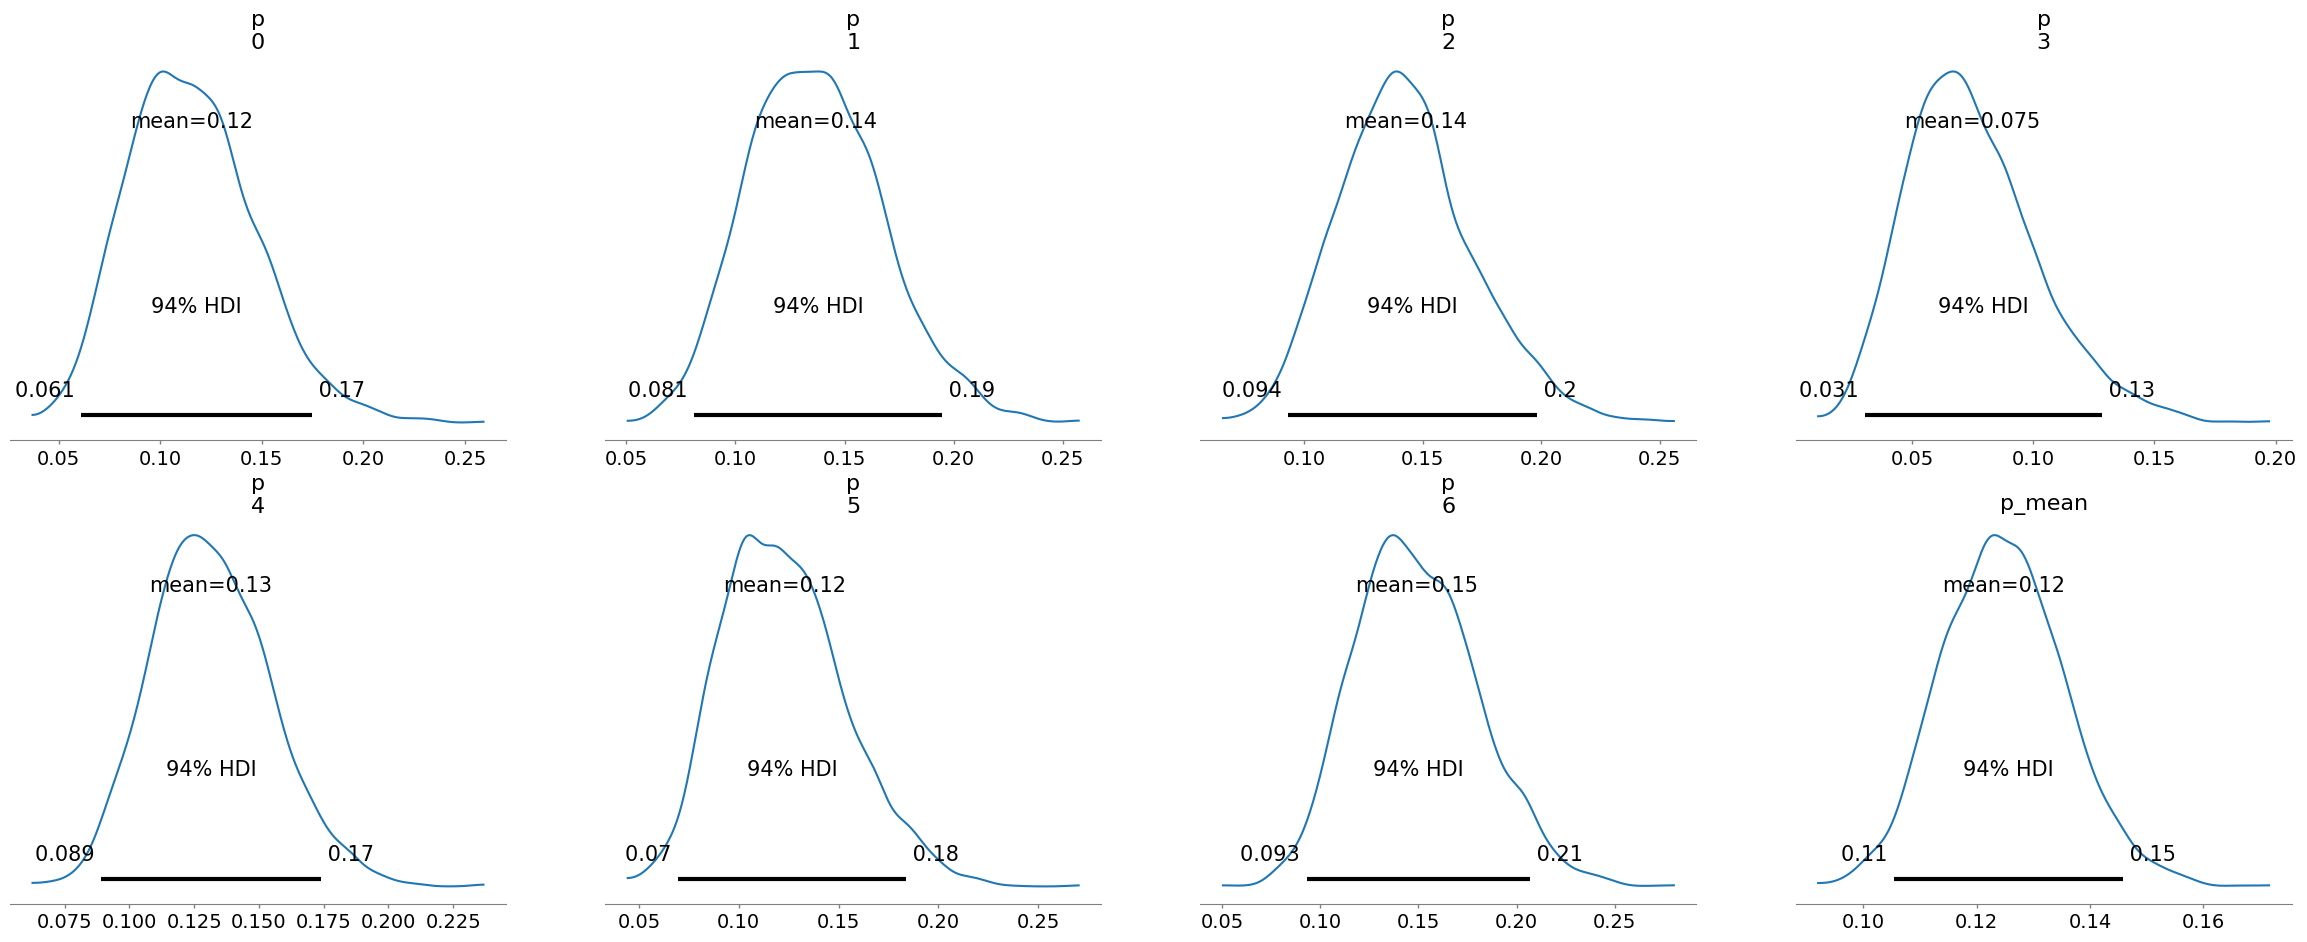

In [ ]:
import arviz

arviz.plot_posterior(trace, var_names=["p", "p_mean"], hdi_prob=0.94)

2.
Valorile de trafic (masini/min.) înregistrate de o camera in jurul unei anumite intersectii din oraş, într-o zi normală,
sunt redate în fişierul trafic.scv (în fiecare minut, de la ora 4:00 până la 24:00). Presupunem că valorile respective sunt
determinate de o distribuţie Poisson de parametru necunoscut λ > 0. Se ştie că modificări ale mediei traficului au loc în
jurul orelor 7, 16 (creştere) şi 8, 19 (descreştere).

a) Definiţi un model probabilist care sa descrie contextul de mai sus, folosind PyMC.

In [9]:
import pymc
import numpy
import pandas

data = pandas.read_csv("trafic.csv")
traffic_data = data["trafic"].values

with pymc.Model() as model:
    change_points = pymc.Normal("change_points", mu=[420, 480, 960, 1140], sigma=10, shape=4)

    lambda_1 = pymc.Exponential("lambda_1", 1/10)
    lambda_2 = pymc.Exponential("lambda_2", 1/10)
    lambda_3 = pymc.Exponential("lambda_3", 1/10)
    lambda_4 = pymc.Exponential("lambda_4", 1/10)
    lambda_5 = pymc.Exponential("lambda_5", 1/10)

    #lambda in functie de intervale
    lambda_rate = pymc.math.switch(
        traffic_data < change_points[0], lambda_1,
        pymc.math.switch(
            traffic_data < change_points[1], lambda_2,
            pymc.math.switch(
                traffic_data < change_points[2], lambda_3,
                pymc.math.switch(
                    traffic_data < change_points[3], lambda_4,
                    lambda_5
                )
            )
        )
    )

    #model de observatie
    traffic_observed = pymc.Poisson("traffic_observed", mu=lambda_rate, observed=traffic_data)

    #markov chain monte carlo
    trace = pymc.sample(2000, tune=1000, random_seed=42, return_inferencedata=True)



Output()

Output()

b) Determinaţi capetele cele mai probabile ale celor 5 intervale de timp, cât şi cele mai probabile valori ale parametrului λ în acele intervale.

array([[<Axes: title={'center': 'change_points\n0'}>,
        <Axes: title={'center': 'change_points\n1'}>,
        <Axes: title={'center': 'change_points\n2'}>],
       [<Axes: title={'center': 'change_points\n3'}>,
        <Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_5'}>]], dtype=object)

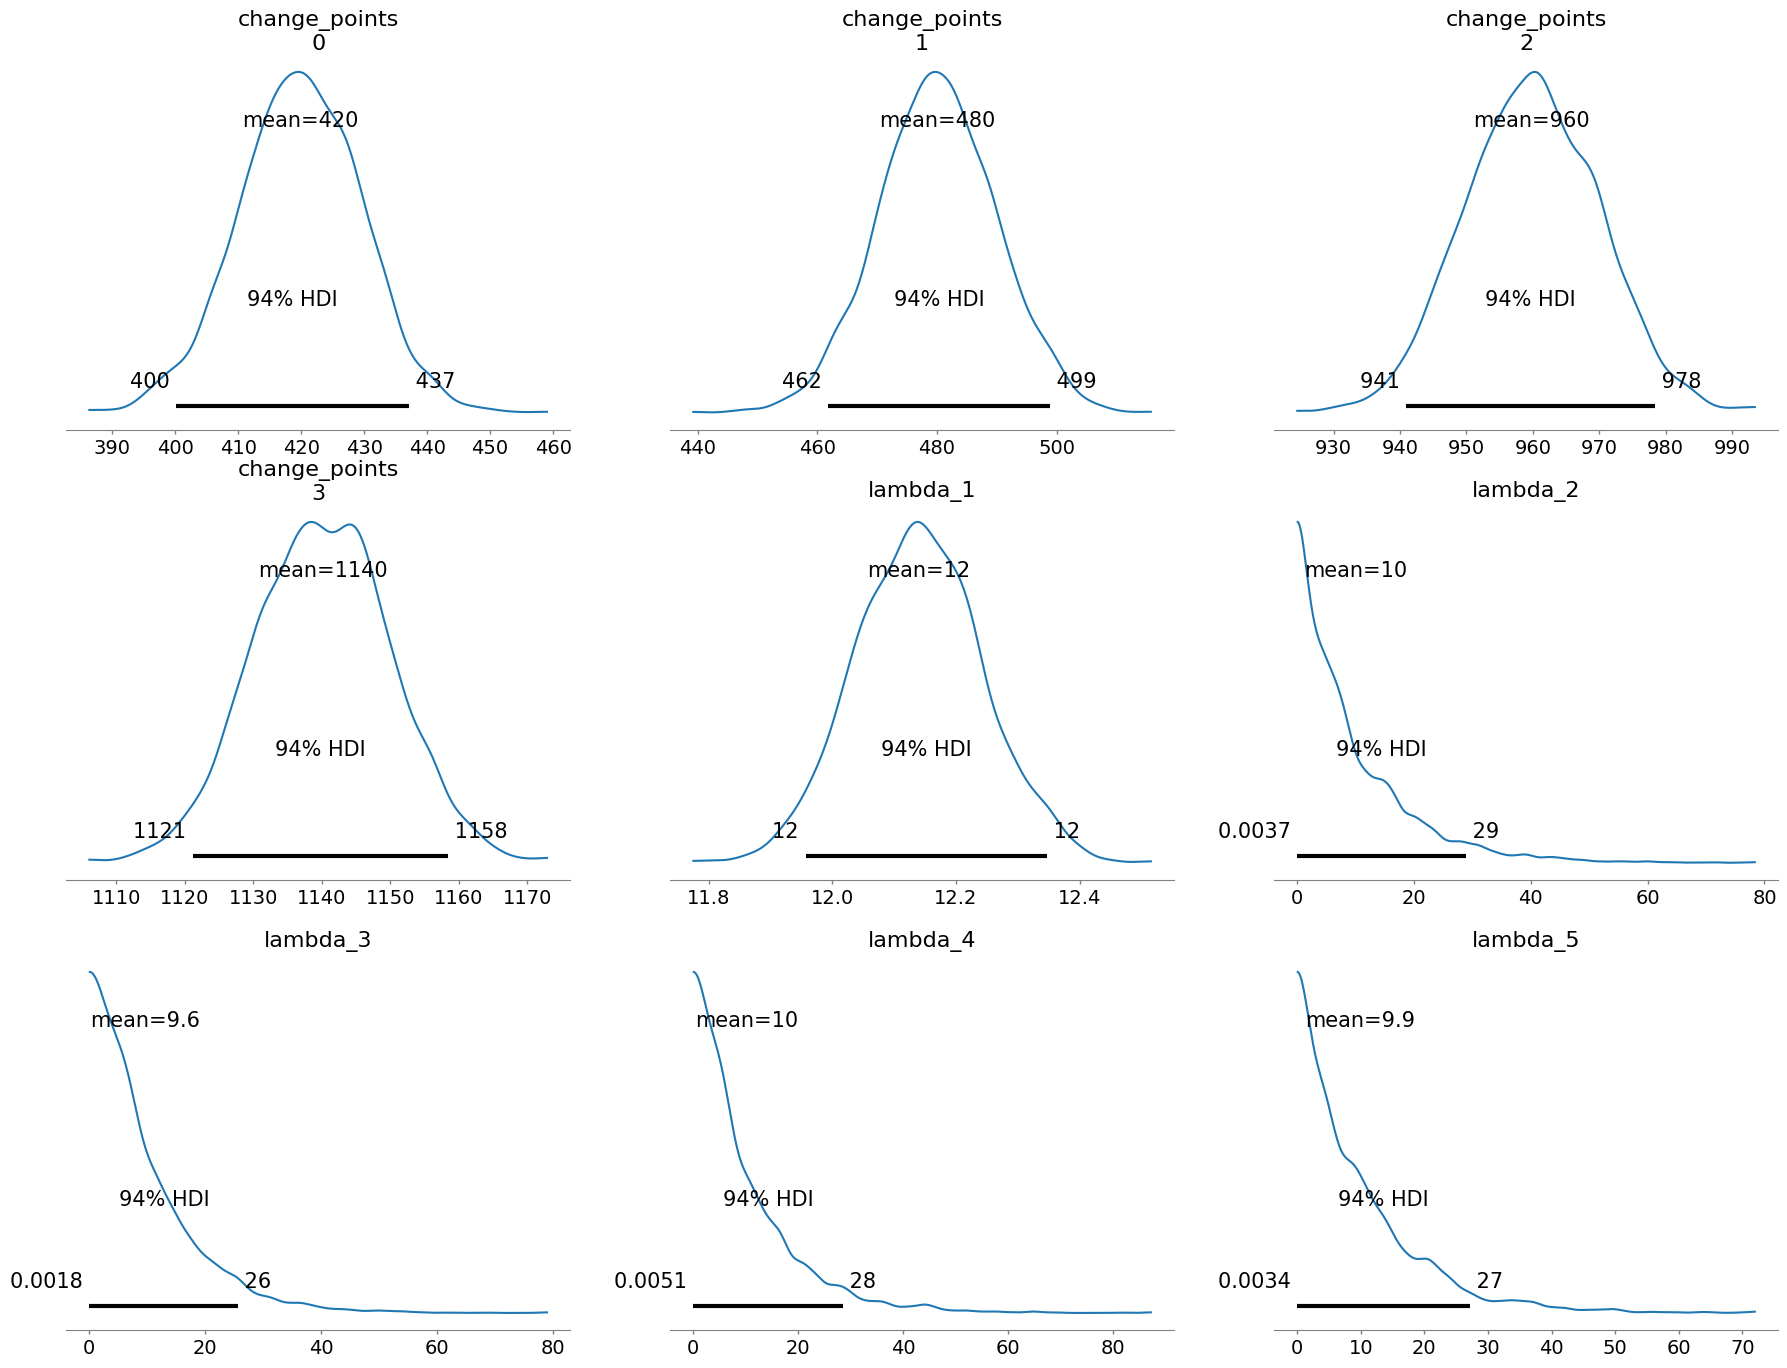

In [10]:
import arviz

arviz.plot_posterior(trace, var_names=["change_points", "lambda_1", "lambda_2", "lambda_3", "lambda_4", "lambda_5"], hdi_prob=0.94)

Cod pentru CSV

In [ ]:
import pandas as pd
import numpy as np

# Generare intervale de minute de la 4:00 (240 minute) la 24:00 (1440 minute)
time_minutes = np.arange(240, 1441)

# Setăm valorile de trafic pentru fiecare interval de timp, cu valori mai mari
traffic_values = []
for minute in time_minutes:
    if 240 <= minute < 420:  # 4:00-7:00, trafic redus
        traffic_values.append(np.random.poisson(10))
    elif 420 <= minute < 480:  # 7:00-8:00, creștere moderată
        traffic_values.append(np.random.poisson(15))
    elif 480 <= minute < 960:  # 8:00-16:00, trafic mediu
        traffic_values.append(np.random.poisson(12))
    elif 960 <= minute < 1140:  # 16:00-19:00, vârf de trafic
        traffic_values.append(np.random.poisson(20))
    else:  # 19:00-24:00, scădere
        traffic_values.append(np.random.poisson(8))

# Creare DataFrame și salvare ca fișier CSV
df = pd.DataFrame({
    "minute_of_day": time_minutes,
    "trafic": traffic_values
})

df.to_csv("trafic.csv", index=False)

# Afișare tabel complet pentru a verifica valorile generate
display(df)


,minute_of_day,trafic
0,240,8
1,241,13
2,242,9
3,243,7
4,244,9
...,...,...
1196,1436,7
1197,1437,10
1198,1438,6
1199,1439,4
